In [1]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

np.random.seed(42)

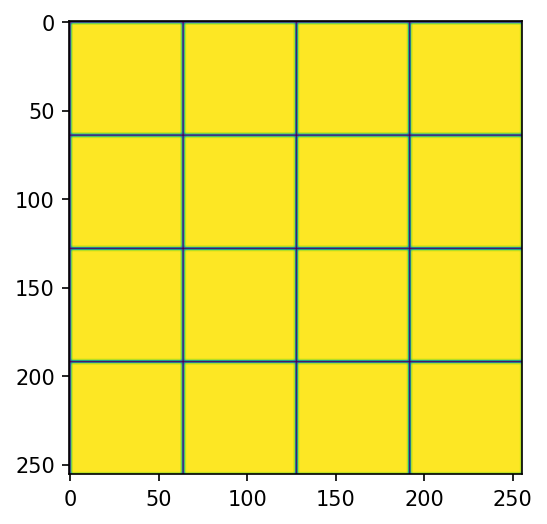

In [2]:
N = 256
grid_spacing = 64

grid = sitk.GridSource(
    outputPixelType=sitk.sitkFloat32,
    size=(N, N),
    sigma=(0.5, 0.5),
    gridSpacing=(grid_spacing, grid_spacing),
    gridOffset=(0, 0),
    spacing=(1, 1),
)

array = sitk.GetArrayViewFromImage(grid)
fig, ax = plt.subplots(dpi=150)
ax.imshow(
    array,
    interpolation='hamming',
);

In [3]:
ctrl_pts = 7, 7
fix_edges = 2

ctrl_pts = np.array(ctrl_pts, np.uint32)
SPLINE_ORDER = 3
mesh_size = ctrl_pts - SPLINE_ORDER
transform = sitk.BSplineTransformInitializer(grid, mesh_size.tolist())
params = transform.GetParameters()

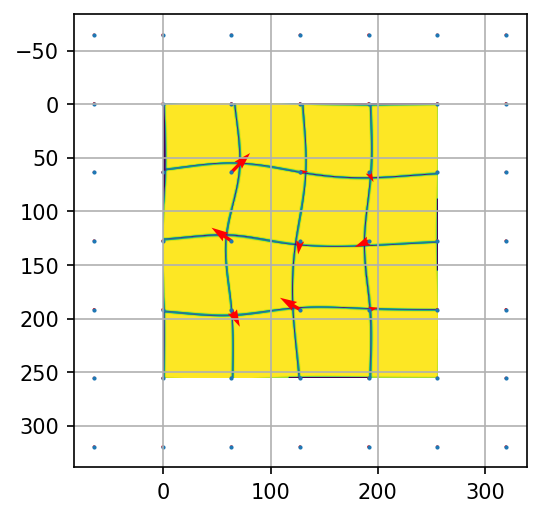

In [4]:
grid_shape = *ctrl_pts, 2

max_displacement = 20
uv = np.random.rand(*grid_shape) - 0.5  # [-0.5, 0.5)
uv *= 2  # [-1, 1)
uv *= max_displacement

#uv *= 0
#uv[3, 2] = -50, 0  # indices are x, y

#std = 20
#uv = np.random.randn(*grid_shape)
#uv *= std


for i in range(fix_edges):
    uv[i, :] = 0
    uv[-1 - i, :] = 0
    uv[:, i] = 0
    uv[:, -1 - i] = 0

transform.SetParameters(uv.flatten(order='F').tolist())
x_coeff, y_coeff = transform.GetCoefficientImages()
grid_origin = x_coeff.GetOrigin()
grid_spacing = x_coeff.GetSpacing()

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(grid)
resampler.SetTransform(transform)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0.5)
resampler.SetOutputPixelType(sitk.sitkFloat32)
resampled = resampler.Execute(grid)

array = sitk.GetArrayViewFromImage(resampled)

fig, ax = plt.subplots(dpi=150)
ax.grid()
ax.imshow(
    array,
    #extent=[
    #    0, resampled.GetSize()[1] * resampled.GetSpacing()[1],
    #    0, resampled.GetSize()[0] * resampled.GetSpacing()[0],
    #],
    interpolation='hamming',
)

x = np.linspace(grid_origin[0], grid_origin[0] + (ctrl_pts[0] - 1) * grid_spacing[0], ctrl_pts[0])
y = np.linspace(grid_origin[1], grid_origin[1] + (ctrl_pts[1] - 1) * grid_spacing[1], ctrl_pts[1])
xx, yy = np.meshgrid(x, y)
u, v = uv[..., 0].T, uv[..., 1].T
ax.quiver(xx, yy, -u, -v, color='red',
          #width=0.0075,
          units='xy', angles='xy', scale_units='xy', scale=1)
ax.scatter(xx, yy, s=1);

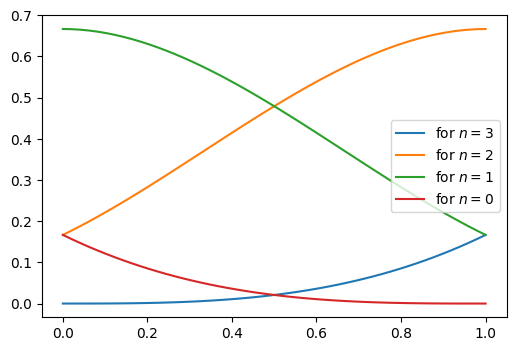

In [5]:
u = np.linspace(0, 1)
fig, ax = plt.subplots(dpi=100)
ax.plot(u, u**3 / 6, label='for $n = 3$')
ax.plot(u, (-3 * u**3 + 3 * u**2 + 3 * u + 1) / 6, label='for $n = 2$')
ax.plot(u, (3 * u**3 - 6 * u**2 + 4) / 6, label='for $n = 1$')
ax.plot(u, (1 - u)**3 / 6, label='for $n = 0$')
ax.legend();

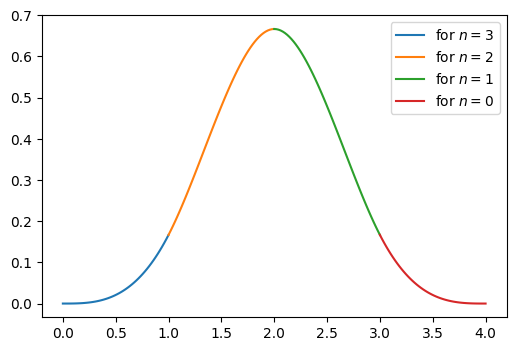

In [6]:
fig, ax = plt.subplots(dpi=100)
u0 = np.linspace(0, 1)
ax.plot(u0, u0**3 / 6, label='for $n = 3$')

u = np.linspace(1, 2)
ax.plot(u, (-3 * u0**3 + 3 * u0**2 + 3 * u0 + 1) / 6, label='for $n = 2$')

u = np.linspace(2, 3)
ax.plot(u, (3 * u0**3 - 6 * u0**2 + 4) / 6, label='for $n = 1$')

u = np.linspace(3, 4)
ax.plot(u, (1 - u0)**3 / 6, label='for $n = 0$')

ax.legend();